## Energy Consumption prediction with MLflow

#### started the mlflow server using:
""" mlflow server `
  --backend-store-uri sqlite:///mlflow.db `
   --default-artifact-root file:/C:/Users/ayakb/Desktop/MLOPS_project/artifacts `
   --host 127.0.0.1 `
  --port 5000 """

In [1]:
from pyngrok import ngrok
import subprocess
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import os
from hyperopt import fmin, tpe, hp, Trials,STATUS_OK
import requests 
from mlflow.models import infer_signature
import json
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.svm import SVR

### Data preprocessing:
- loaded data.
- transformed 'Date' and 'Time' into a single datetime type column.
- resampled by daily Global active power instead of hourly.
- added lag features
- split data 80/20

In [2]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
df = individual_household_electric_power_consumption.data.features

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)


c:\Users\ayakb\Desktop\MLOPS_project\.venv\Lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [ ]:
#Transform Date and Time column to a single datetime type column
df["datetime"]=pd.to_datetime(df['Date']+ " " + df['Time'],format="%d/%m/%Y %H:%M:%S")
df.set_index("datetime",inplace=True)
df.drop(columns=["Date","Time"],inplace=True)

In [ ]:
#make sur all data is numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
#resample data for daily consumption instead of hourly
df_daily = df.resample('D').mean()

In [6]:
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


In [ ]:
#added 2 lag features to simulate trends
df_daily["lag_1"]=df_daily['Global_active_power'].shift(1)
df_daily["lag_2"]=df_daily['Global_active_power'].shift(2)
df_daily.dropna(inplace=True)

In [8]:
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,lag_1,lag_2
datetime,,,,,,,,,
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,2.354486,3.053475
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,1.530435,2.354486
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,1.157079,1.530435
2006-12-21,1.193758,0.100255,241.040549,5.033797,1.227399,1.824061,7.246871,1.545658,1.157079
2006-12-22,1.625929,0.129796,241.184549,6.872917,2.188194,0.243056,7.729861,1.193758,1.545658


In [9]:
X=df_daily.drop(columns=["Global_active_power"])
y=df_daily["Global_active_power"]

In [ ]:
#data split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

### Model training and hyperparameter tuning:
- Initialized spaces for model traing and hyperparameter tuning.
- logged metrics,parameters, and model artifacts to MLflow.
- combared the best performing models using a histogram.
- best performing model was linear regression.
- saved the best model for regitry.

In [ ]:
# initialize models
models={
    "LinearRegression":LinearRegression(),
    "XGBoost":xgb.XGBRegressor(n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42),
    "RandomForest":RandomForestRegressor(n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42),
    "SVR":SVR(kernel='rbf',
        C=10,
        epsilon=0.2,
        gamma='scale')
}

In [12]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("MLOPS_project")

<Experiment: artifact_location='file:///C:/Users/ayakb/Desktop/MLOPS_project/artifacts/1', creation_time=1745753855145, experiment_id='1', last_update_time=1745753855145, lifecycle_stage='active', name='MLOPS_project', tags={}>

In [13]:
import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

In [14]:
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # Train
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, preds)
        mae=mean_absolute_error(y_test,preds)
        mse=mean_squared_error(y_test,preds)

        # Log metadata
        mlflow.log_param("model", model_name)
        if hasattr(model, 'get_params'):
            for param, value in model.get_params().items():
                mlflow.log_param(param, value)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mse",mse)
        mlflow.log_metric("mae",mae)
        signature = infer_signature(X_train,preds)
        mlflow.sklearn.log_model(model, "model",signature=signature,input_example=X_train)

        print(f"{model_name} → RMSE: {rmse}")
        print(f"{model_name} → MSE: {mse}")
        print(f"{model_name} → MAE: {mae}")

c:\Users\ayakb\Desktop\MLOPS_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LinearRegression → RMSE: 0.00979620332355225
LinearRegression → MSE: 9.596559955637618e-05
LinearRegression → MAE: 0.007302941183021884
🏃 View run LinearRegression at: http://127.0.0.1:5000/#/experiments/1/runs/434944fb82674703be26d8af95db6fc0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


XGBoost → RMSE: 0.045326507051039557
XGBoost → MSE: 0.0020544922414479387
XGBoost → MAE: 0.02985203428564949
🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/1/runs/1582051bd1ca45459b5aa51ef5306b2c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


RandomForest → RMSE: 0.07423069694619253
RandomForest → MSE: 0.005510196369117476
RandomForest → MAE: 0.04341174295570888
🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/1/runs/f4164b6bc2c04dce9ad182ee457cacec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


SVR → RMSE: 0.13241173183354982
SVR → MSE: 0.017532866727159913
SVR → MAE: 0.1041680183235914
🏃 View run SVR at: http://127.0.0.1:5000/#/experiments/1/runs/8af097308cf24ee48ee00040b348b4fb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
# space for hyperparameter tuning
model_params = {
    "LinearRegression":{
        "model":LinearRegression,
        "space":{}
    },
    "RandomForest": {
        "model": RandomForestRegressor,
        "space": {
            "n_estimators": hp.choice("n_estimators", [100, 200, 300]),
            "max_depth": hp.choice("max_depth", [5, 10, 15, None]),
            "min_samples_split": hp.uniform("min_samples_split", 0.01, 0.1),
            "min_samples_leaf": hp.uniform("min_samples_leaf", 0.01, 0.1)
        }
    },
    "SVR": {
        "model": SVR,
        "space": {
            "C": hp.loguniform("C", np.log(0.1), np.log(100)),
            "epsilon": hp.uniform("epsilon", 0.01, 0.2),
            "kernel": hp.choice("kernel", ["rbf", "linear"])
        }
    },
    "XGBoost": {
        "model": xgb.XGBRegressor,
        "space": {
            "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
            "max_depth": hp.choice("max_depth", [3, 6, 10]),
            "n_estimators": hp.choice("n_estimators", [100, 200, 300]),
            "subsample": hp.uniform("subsample", 0.6, 1.0),
            "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0)
        }
    }
}

In [36]:
mlflow.end_run()

In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import pandas as pd

results = []
best_overall = {"rmse": float("inf"), "model": None, "run_id": None}

for model_name, config in model_params.items():
    print(f"\n🔍 Tuning: {model_name}")

    space = config["space"]
    ModelClass = config["model"]
    best_metrics = {"rmse": float("inf"), "mae": None, "mse": None, "run_id": None}

    def objective(params):
        with mlflow.start_run(run_name=f"{model_name}_trial", nested=True) as run:
            model = ModelClass(**params) if params else ModelClass()
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            rmse = root_mean_squared_error(y_test, preds)
            mae = mean_absolute_error(y_test, preds)
            mse = mean_squared_error(y_test, preds)

            mlflow.log_params(params)
            mlflow.log_metrics({"rmse": rmse, "mae": mae, "mse": mse})
            mlflow.sklearn.log_model(model, "model", signature=infer_signature(X_train, preds), input_example=X_train)

            if rmse < best_metrics["rmse"]:
                best_metrics["rmse"] = rmse
                best_metrics["mae"] = mae
                best_metrics["mse"] = mse
                best_metrics["run_id"] = run.info.run_id  # Save nested run ID with best model

            return {"loss": rmse, "status": STATUS_OK}
    
    with mlflow.start_run(run_name=f"{model_name}_tuning") as run:
        if space:
            trials = Trials()  # started a Trial for hyperparameter tuning
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)
            mlflow.log_params(best)
        else:
            model = ModelClass()
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            rmse = root_mean_squared_error(y_test, preds)
            mae = mean_absolute_error(y_test, preds)
            mse = mean_squared_error(y_test, preds)

            mlflow.log_metrics({"rmse": rmse, "mae": mae, "mse": mse})
            mlflow.sklearn.log_model(model, "model", signature=infer_signature(X_train, preds), input_example=X_train)
            
            best_metrics = {"rmse": rmse, "mae": mae, "mse": mse, "run_id": run.info.run_id}

        # Save best model run for comparison
        results.append({"model": model_name, **best_metrics})

        if best_metrics["rmse"] < best_overall["rmse"]:
            best_overall["rmse"] = best_metrics["rmse"]
            best_overall["model"] = model_name
            best_overall["run_id"] = best_metrics["run_id"]  # Use run with model logged



🔍 Tuning: LinearRegression


🏃 View run LinearRegression_tuning at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/44410bc693b740fb93eda45a08ebfdb9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126

🔍 Tuning: RandomForest
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/14a0b697103c417db10be739e3550b5b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126

  4%|▍         | 1/25 [00:03<01:25,  3.57s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/0fd296a69d594e5cbc0af7f991a46e2d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

  8%|▊         | 2/25 [00:06<01:19,  3.46s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/d1fd7adeddcf46b0bd389b018b868235

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 12%|█▏        | 3/25 [00:10<01:13,  3.36s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/ad44b424641549789a1adf8409e6f73d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 16%|█▌        | 4/25 [00:13<01:11,  3.42s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/9fc3bf4b9d144fc0a2611460f35c3e4c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 20%|██        | 5/25 [00:17<01:08,  3.44s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/ae4fe0a05bb449a0a0cdbeb0e1fcc894

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 24%|██▍       | 6/25 [00:20<01:04,  3.42s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/d0955dfd06b24cbf8b4018fb471cef18

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 28%|██▊       | 7/25 [00:23<00:59,  3.33s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/7c41000927164d779f3c118923b3c12f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 32%|███▏      | 8/25 [00:26<00:55,  3.25s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/4a7e0fa26d4843f891752add87207c99

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 36%|███▌      | 9/25 [00:30<00:52,  3.25s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/8ab6bf8672cc4aa58eff2cfbd7faf6f7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 40%|████      | 10/25 [00:33<00:48,  3.23s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/6e56c04dbed848dfb7a385a38286b925

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 44%|████▍     | 11/25 [00:36<00:44,  3.21s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/f3704b52ee5844abbd22f25e48dac144

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 48%|████▊     | 12/25 [00:39<00:41,  3.20s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/f4761cdf757445b2ab29270e2e0a1d16

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 52%|█████▏    | 13/25 [00:42<00:38,  3.22s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/5e8961a1b7be4b29a6f7d498f4b374bf

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 56%|█████▌    | 14/25 [00:46<00:35,  3.23s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/0464d4e50a19407786cf55de106980d7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 60%|██████    | 15/25 [00:49<00:32,  3.25s/trial, best loss: 0.036799944033873544]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/5c6940936f0f4b6e8330b1ffd0e61824

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 64%|██████▍   | 16/25 [00:52<00:29,  3.22s/trial, best loss: 0.03438322556776826] 

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/c0c08efda73a4ac8b21ab11538b2bc1d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 68%|██████▊   | 17/25 [00:55<00:25,  3.20s/trial, best loss: 0.03438322556776826]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/aabe2d4eb3f24a6aa8b9b9bbc81110e6

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 72%|███████▏  | 18/25 [00:58<00:22,  3.17s/trial, best loss: 0.03438322556776826]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/672c31baef594f0ea33104c48106d4e2

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 76%|███████▌  | 19/25 [01:01<00:18,  3.15s/trial, best loss: 0.03438322556776826]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/b8c4ec29e22e48d7b7a807fa6b95f069

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 80%|████████  | 20/25 [01:05<00:15,  3.15s/trial, best loss: 0.03438322556776826]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/481afd7928724a12a02f6346ae4ece31

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 84%|████████▍ | 21/25 [01:08<00:13,  3.34s/trial, best loss: 0.03397912699136484]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/c07febdfbb944b699438816048323400

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 88%|████████▊ | 22/25 [01:12<00:10,  3.35s/trial, best loss: 0.03397912699136484]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/af125d16aff84fbca9d0314d7cc17d93

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 92%|█████████▏| 23/25 [01:15<00:06,  3.40s/trial, best loss: 0.03397912699136484]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/604a7b120b424bbea51d3d1782c885a6

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 96%|█████████▌| 24/25 [01:19<00:03,  3.45s/trial, best loss: 0.03397912699136484]

🏃 View run RandomForest_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/a15dd6c7dd28421ca191c61a2d3ff594

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

100%|██████████| 25/25 [01:22<00:00,  3.31s/trial, best loss: 0.03397912699136484]
🏃 View run RandomForest_tuning at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/a5fe4580a552428fbe959cf44a0a32c5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126

🔍 Tuning: SVR
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/9e2f4dbe7f5047e2828a0aa8c9078555

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126

  4%|▍         | 1/25 [00:02<01:05,  2.73s/trial, best loss: 0.06404461265086264]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/373c24b234414797916461bb66c65a19

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

  8%|▊         | 2/25 [00:05<01:02,  2.74s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/4ee6eb7c1d1f42ccb1aa2304ceeb2ebd

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

 12%|█▏        | 3/25 [00:08<01:00,  2.76s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/69d56ddefe684fc394c9d1a8777ec589

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

 16%|█▌        | 4/25 [00:10<00:57,  2.74s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/282a41ceed1544a49115878c7e734778

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

 20%|██        | 5/25 [00:13<00:55,  2.76s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/c8e8fbaa15184afcbcdf90768325fc79

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

 24%|██▍       | 6/25 [00:16<00:52,  2.78s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/4b3fb8d9f527485c98d3e71eb00cf778

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

 28%|██▊       | 7/25 [00:19<00:50,  2.83s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/2f9c3ab2467348999a36d9a25b2b3d99

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

 32%|███▏      | 8/25 [00:22<00:47,  2.81s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/7dafc01445344970a37ac28475abc847

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

 36%|███▌      | 9/25 [00:25<00:44,  2.81s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/6dd4a73702674627a5e63fd0e43d981e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126    

 40%|████      | 10/25 [00:27<00:42,  2.82s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/17039a637bec4af5bf12f7e5888afc6d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 44%|████▍     | 11/25 [00:30<00:39,  2.83s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/e014fae2642041659c65abfd005a1321

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 48%|████▊     | 12/25 [00:33<00:37,  2.85s/trial, best loss: 0.03847543237588842]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/662a92aaf5ba441f97994394a261ef30

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 52%|█████▏    | 13/25 [00:36<00:34,  2.85s/trial, best loss: 0.026345670473972304]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/d73c60caf5ae4963837e085f23c92f97

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 56%|█████▌    | 14/25 [00:39<00:31,  2.83s/trial, best loss: 0.012689936744384928]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/71e93cd192a1447a81aecde6fc02f961

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 60%|██████    | 15/25 [00:42<00:28,  2.81s/trial, best loss: 0.012689936744384928]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/cac7ec2b81e644ecaa459b8d0240312f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 64%|██████▍   | 16/25 [00:44<00:25,  2.82s/trial, best loss: 0.012689936744384928]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/359390c66fc041e1a7523cfe4af81efd

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 68%|██████▊   | 17/25 [00:47<00:22,  2.83s/trial, best loss: 0.012689936744384928]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/04e5fe4c44084c0eb8a1728f21ca743c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 72%|███████▏  | 18/25 [00:50<00:19,  2.82s/trial, best loss: 0.012689936744384928]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/a30bc3b69be04d4b99a9d6a867660411

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 76%|███████▌  | 19/25 [00:53<00:16,  2.81s/trial, best loss: 0.012689936744384928]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/b1427b3edd094b74bd3c6402f07c2f01

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 80%|████████  | 20/25 [00:56<00:14,  2.82s/trial, best loss: 0.012689936744384928]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/ec2f12c68aca4a16afc27787e9757f63

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 84%|████████▍ | 21/25 [00:59<00:11,  2.83s/trial, best loss: 0.010579239130985997]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/457dbedb3b2744b193b93ed07ac65910

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 88%|████████▊ | 22/25 [01:01<00:08,  2.82s/trial, best loss: 0.010579239130985997]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/0e74c5247c184395b5029d65ed0cd88e

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 92%|█████████▏| 23/25 [01:04<00:05,  2.80s/trial, best loss: 0.010579239130985997]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/60ee98f78326495badaaea2a785f2495

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 96%|█████████▌| 24/25 [01:07<00:02,  2.82s/trial, best loss: 0.010579239130985997]

🏃 View run SVR_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/4dae9e90cc5e4eb39cd0b4cd684a6103

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

100%|██████████| 25/25 [01:10<00:00,  2.81s/trial, best loss: 0.010579239130985997]
🏃 View run SVR_tuning at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/ad73da59b1cd464792eab48f3c76eb86
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126

🔍 Tuning: XGBoost
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/e872580a58f34f8e88911d9561d3e635

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126

  4%|▍         | 1/25 [00:03<01:14,  3.09s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/6c75ff53bb2b4dffb9fd21258f474336

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

  8%|▊         | 2/25 [00:06<01:09,  3.03s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/5dd2b4bcb1cb47d9999552655f12d484

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 12%|█▏        | 3/25 [00:09<01:06,  3.02s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/65b9b37084b840e5b1541fc10204f478

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 16%|█▌        | 4/25 [00:12<01:04,  3.08s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/18869ac2332345a6be471aa3e9f177e5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 20%|██        | 5/25 [00:15<01:01,  3.07s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/ae81a301bf7b4a8d8d73030e60818b1b

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 24%|██▍       | 6/25 [00:18<00:58,  3.10s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/6d3c5250902e4c4e950f9adeb000cae4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 28%|██▊       | 7/25 [00:21<00:55,  3.09s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/fdff8855790c4b0783d61100e4edd91c

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 32%|███▏      | 8/25 [00:24<00:52,  3.10s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/a39e5be5019e4d30bd5aa0c357e78815

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 36%|███▌      | 9/25 [00:28<00:51,  3.21s/trial, best loss: 0.026760204543294877]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/c6d4b23f07cf4f8b9a7de00e88541a4d

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126     

 40%|████      | 10/25 [00:31<00:47,  3.15s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/c80b13ff26814153b77114e1f4c63848

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 44%|████▍     | 11/25 [00:34<00:44,  3.18s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/9a3e50cbb68d4c7a83aa88d53b683ba3

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 48%|████▊     | 12/25 [00:37<00:40,  3.15s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/bab73baae7f54a43b675803f84bae250

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 52%|█████▏    | 13/25 [00:40<00:38,  3.20s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/284ec6ec4feb4352b5d58c297eb9b8e4

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 56%|█████▌    | 14/25 [00:44<00:35,  3.21s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/571d4f342d784572897f55a5e81c345f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 60%|██████    | 15/25 [00:47<00:31,  3.17s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/ef2e0f08a58445fc99ffc24248308132

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 64%|██████▍   | 16/25 [00:50<00:28,  3.17s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/256ddcb6d98246d18e569916a7aa5aab

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 68%|██████▊   | 17/25 [00:53<00:25,  3.23s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/c57dcb577390425f8b57a64eabd03d0f

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 72%|███████▏  | 18/25 [00:56<00:22,  3.25s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/bf1e8d5d100f43b183309033ef61caf7

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 76%|███████▌  | 19/25 [01:00<00:19,  3.25s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/33f02d71eebb4426977cf9484786e854

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 80%|████████  | 20/25 [01:03<00:16,  3.29s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/a5233739d37541d3b7c92585b7be2127

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 84%|████████▍ | 21/25 [01:07<00:13,  3.35s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/6ad13a836b8946de8736b4ac3be03026

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 88%|████████▊ | 22/25 [01:10<00:10,  3.34s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/73034491bda041898c6bea8f08eea802

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 92%|█████████▏| 23/25 [01:13<00:06,  3.37s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/4a90af90bf8b4f4da424ef0b74621d13

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

 96%|█████████▌| 24/25 [01:16<00:03,  3.31s/trial, best loss: 0.024463471894390503]

🏃 View run XGBoost_trial at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/dcbe3f67659142f7bd922390eba09f92

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126      

100%|██████████| 25/25 [01:20<00:00,  3.20s/trial, best loss: 0.024463471894390503]
🏃 View run XGBoost_tuning at: http://127.0.0.1:5000/#/experiments/184415391709998126/runs/68220b7c6cdf4fd3be0e649c468385dd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/184415391709998126


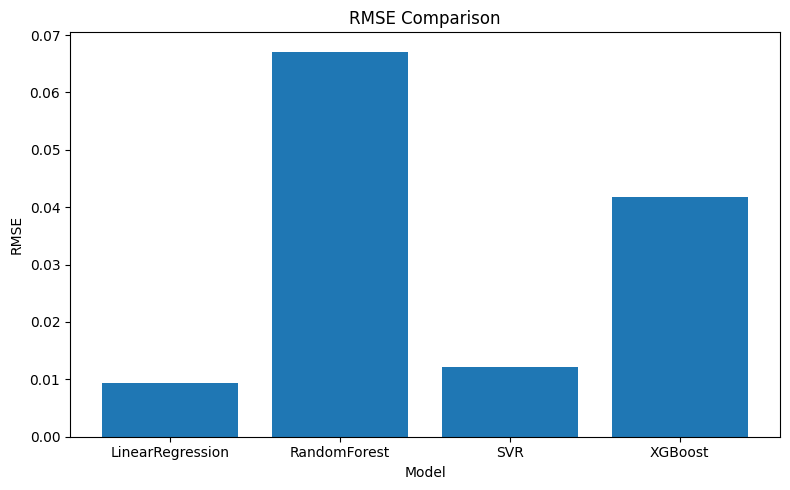

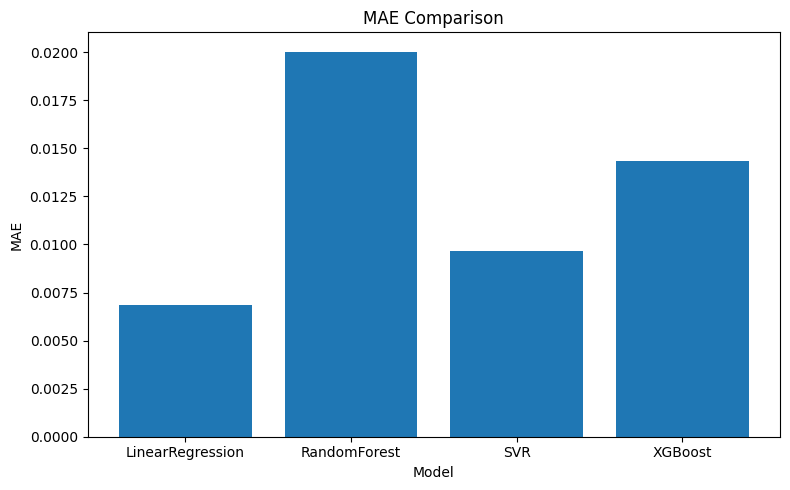

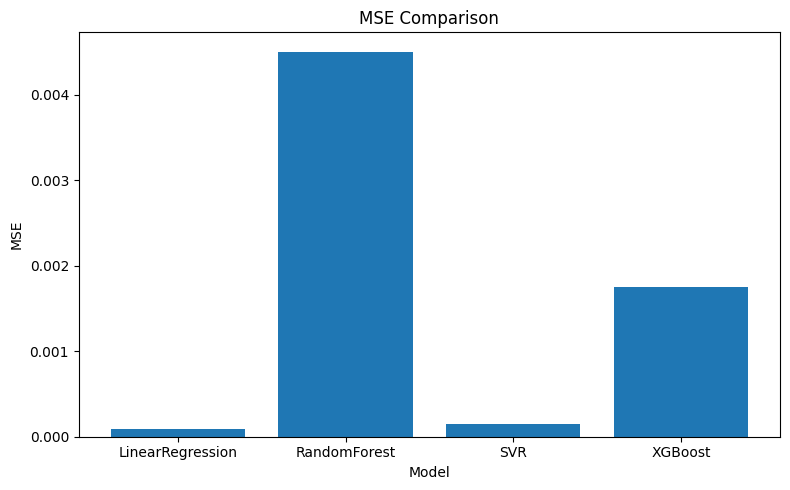

In [ ]:
# create a histogram with the best performing models
df_results = pd.DataFrame(results)
for metric in ["rmse", "mae", "mse"]:
    plt.figure(figsize=(8, 5))
    plt.bar(df_results["model"], df_results[metric])
    plt.title(f"{metric.upper()} Comparison")
    plt.ylabel(metric.upper())
    plt.xlabel("Model")
    plt.tight_layout()
    chart_path = f"{metric}_comparison.png"
    plt.savefig(chart_path)
    mlflow.log_artifact(chart_path)


In [21]:
df_results.head(10)

,model,rmse,mae,mse
0,LinearRegression,0.009334,0.006876,0.000087
1,RandomForest,0.067111,0.020034,0.004504
2,SVR,0.012113,0.009682,0.000147
3,XGBoost,0.041859,0.014317,0.001752


### Model Regitry,Deployment and Monitoring:
- registered the best model and set it to 'Production'
- set the tracking Ui using '$env:MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"'
- then served the model using 'mlflow models serve --model-uri models:/Best_Regression_Model/1 --no-conda --port 5001'
- sent a POST request with test data to test the served model
- created a monitorong run that logs predictions and inference time.

In [ ]:
# register the best model and set it to 'Production'
if best_overall["run_id"]:
    model_uri = f"runs:/{best_overall['run_id']}/model"
    registered_model_name = "Best_Regression_Model"

    result = mlflow.register_model(model_uri=model_uri, name=registered_model_name)

    client = MlflowClient()
    client.transition_model_version_stage(
        name=registered_model_name,
        version=result.version,
        stage="Production",
        archive_existing_versions=True
    )

    print(f"\n✅ Registered '{best_overall['model']}' as the best model (RMSE: {best_overall['rmse']:.4f})")

Successfully registered model 'Best_Regression_Model'.
2025/04/27 20:44:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Regression_Model, version 1
Created version '1' of model 'Best_Regression_Model'.
C:\Users\ayakb\AppData\Local\Temp\ipykernel_12008\3919503307.py:8: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(



✅ Registered 'LinearRegression' as the best model (RMSE: 0.0093)


In [27]:
print(mlflow.get_tracking_uri())

http://127.0.0.1:5000


In [28]:
import requests
import json

# Feature columns
columns = [
    "Global_reactive_power", "Voltage", "Global_intensity",
    "Sub_metering_1", "Sub_metering_2", "Sub_metering_3",
    "lag_1", "lag_2"
]

# Input values for one row
values = [[
    0.104821, 241.999313, 4.926389,
    0.582639, 5.279167, 4.303472,
    1.530435, 2.354486
]]

# This time, correctly nested under "dataframe_split"
payload = {
    "dataframe_split": {
        "columns": columns,
        "data": values
    }
}

# Send the request
response = requests.post(
    url="http://127.0.0.1:5001/invocations",
    headers={"Content-Type": "application/json"},
    data=json.dumps(payload)
)

# Output
print("Prediction:", response.json())


Prediction: {'predictions': [1.16587505080282]}


In [30]:
mlflow.end_run()

🏃 View run unique-moth-114 at: http://127.0.0.1:5000/#/experiments/1/runs/5f3c2e15a0764ac4a27549e51d65e6f2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [31]:
from sklearn.metrics import mean_squared_error
import mlflow

# True and predicted values
y_true = [1.157079]
y_pred = response.json()["predictions"]  # Extract the prediction list

# Log metrics
with mlflow.start_run(run_name="monitoring_run"):
    mse = mean_squared_error(y_true, y_pred)
    mlflow.log_metric("mse", mse)
    print("MSE logged:", mse)


MSE logged: 7.737050972578996e-05
🏃 View run monitoring_run at: http://127.0.0.1:5000/#/experiments/1/runs/82487c5ed2244a1bb1bae831e9a3c5be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [32]:
import requests
import json
import time
import mlflow

# Start a new MLflow run to log metrics
with mlflow.start_run(run_name="model_monitoring"):

    # Corrected payload with the new format (using 'instances')
    payload = {
        "instances": [
            {
                "Global_reactive_power": 0.146225156,
                "Voltage": 240.017637,
                "Global_intensity": 4.45031272,
                "Sub_metering_1": 1.42876998,
                "Sub_metering_2": 2.59416261,
                "Sub_metering_3": 8.42043085,
                "lag_1": 0.187794444,
                "lag_2": 0.185825000
            }
        ]
    }

    # Record the start time for inference
    start_time = time.time()

    # Send POST request to the served model
    response = requests.post(
        url="http://127.0.0.1:5001/invocations",
        headers={"Content-Type": "application/json"},
        data=json.dumps(payload)
    )

    # Calculate inference time
    inference_time = time.time() - start_time

    # Print the full response text for debugging
    print(f"Response Status Code: {response.status_code}")
    print(f"Response Text: {response.text}")

    if response.status_code == 200:
        response_data = response.json()
        print(f"Response JSON: {response_data}")  # Print the raw response for debugging

        if "predictions" in response_data:
            prediction = response_data["predictions"][0]  # Adjusted to use 'predictions' instead of 'prediction'
            print(f"Prediction: {prediction}")
            
            # Log metrics to MLflow
            mlflow.log_metric("inference_time", inference_time)
            mlflow.log_metric("prediction", prediction)  # Example: logging the prediction as a metric
        else:
            print("Predictions key not found in response.")
    else:
        print(f"Error: {response.status_code}")


Response Status Code: 200
Response Text: {"predictions": [1.0433678731657254]}
Response JSON: {'predictions': [1.0433678731657254]}
Prediction: 1.0433678731657254
🏃 View run model_monitoring at: http://127.0.0.1:5000/#/experiments/1/runs/b5ddcf58c78b441e81d9bb777a855138
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
